In [ ]:
import xml.etree.ElementTree as ET

def parse_xml_single_file(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    annotations = {}

    for image in root.iter('image'):
        image_name = image.get('name')  # Assuming image names are specified in the 'name' attribute
        keypoints = []

        for keypoint in image.iter('keypoint'):
            x = int(keypoint.find('x').text)
            y = int(keypoint.find('y').text)
            visibility = int(keypoint.find('visibility').text)
            keypoints.append((x, y, visibility))  # (x, y, visibility)

        annotations[image_name] = keypoints

    return annotations

# Example usage
annotations = parse_xml_single_file('/content/dataset/annotations/annotations.xml')
print(annotations)


{'PE/0.jpg': [], 'PE/1.jpg': [], 'PE/10.jpg': [], 'PE/11.jpg': [], 'PE/12.jpg': [], 'PE/13.jpg': [], 'PE/14.jpg': [], 'PE/15.jpg': [], 'PE/16.jpg': [], 'PE/17.jpg': [], 'PE/18.jpg': [], 'PE/19.jpg': [], 'PE/2.JPG': [], 'PE/20.jpg': [], 'PE/21.jpg': [], 'PE/22.jpg': [], 'PE/23.jpg': [], 'PE/24.jpg': [], 'PE/25.jpg': [], 'PE/26.jpg': [], 'PE/27.jpg': [], 'PE/28.jpg': [], 'PE/3.jpg': [], 'PE/4.jpg': [], 'PE/5.jpg': [], 'PE/6.jpg': [], 'PE/7.jpg': [], 'PE/8.jpg': [], 'PE/9.jpg': []}


In [ ]:
import os
import cv2
from torch.utils.data import Dataset
from PIL import Image

class PoseDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = parse_xml_single_file(annotations_file)
        self.img_dir = img_dir
        self.image_files = list(self.annotations.keys())  # Use image filenames from the annotations
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image using cv2
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found at {img_path}")
            return None, None

        # Convert image from BGR (OpenCV) to RGB (PIL expects RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert image to PIL format before applying transformations
        image = Image.fromarray(image)

        # Get keypoints
        keypoints = self.annotations[img_name]

        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)  # Should be a Tensor after this step

        return image, torch.tensor(keypoints)


In [ ]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize image
    transforms.ToTensor()            # Convert to Tensor
])

# Instantiate the dataset
dataset = PoseDataset(
    annotations_file='/content/dataset/annotations/annotations.xml',
    img_dir='/content/dataset/Images',
    transform=transform
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Test a batch
images, keypoints = next(iter(dataloader))
print(images.shape, keypoints.shape)


torch.Size([8, 3, 256, 256]) torch.Size([8, 0])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN for pose estimation
class PoseEstimationModel(nn.Module):
    def __init__(self, num_keypoints):
        super(PoseEstimationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 64 * 64, 1024)
        self.fc2 = nn.Linear(1024, num_keypoints * 2)  # Predicting x, y coordinates for keypoints

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, num_keypoints, 2)

# Initialize the model
num_keypoints = 17  # Assuming 17 keypoints as in COCO dataset
model = PoseEstimationModel(num_keypoints)


In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
if keypoints.dim() == 2 and keypoints.shape[1] % 2 == 0:
    # Reshape keypoints from [batch_size, num_keypoints] to [batch_size, num_keypoints // 2, 2]
    keypoints = keypoints.view(keypoints.size(0), -1, 2)
    print(f"Reshaped keypoints to: {keypoints.shape}")


Reshaped keypoints to: torch.Size([8, 0, 2])


In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, keypoints in dataloader:
        # Move to GPU if available
        if keypoints.nelement() == 0:
          continue # Skip iteration if no keypoints

        images = images.float()
        keypoints = keypoints.float()

        optimizer.zero_grad()
        outputs = model(images)

        # Ignore the visibility dimension if present and reshape keypoints to match predictions
        if keypoints.dim() == 3:
          keypoints = keypoints[:, :, :2]  # We are only interested in (x, y)

        # Compute loss
        loss = criterion(outputs, keypoints)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


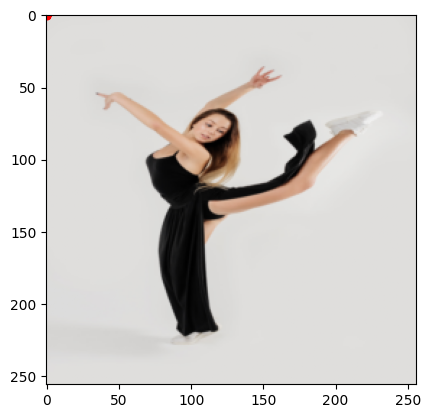

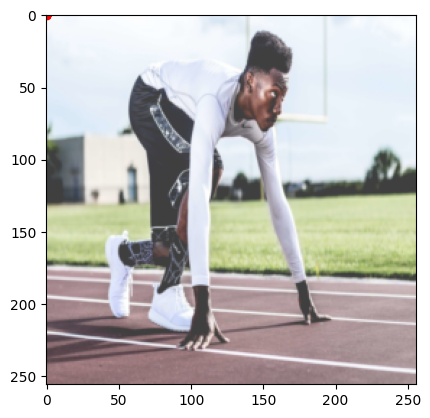

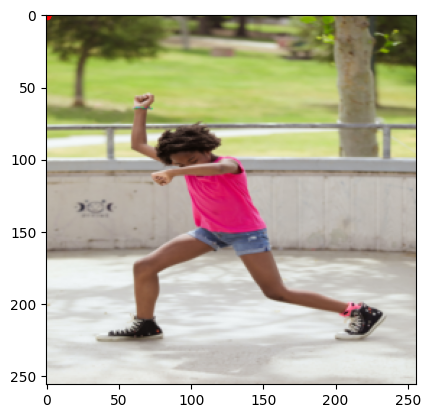

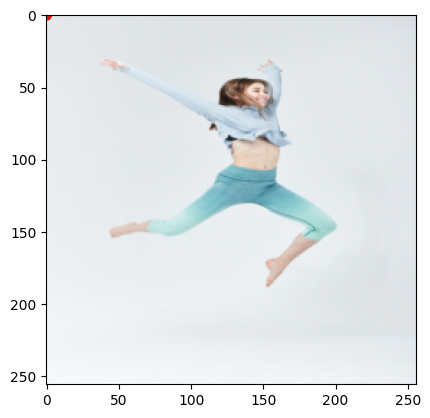

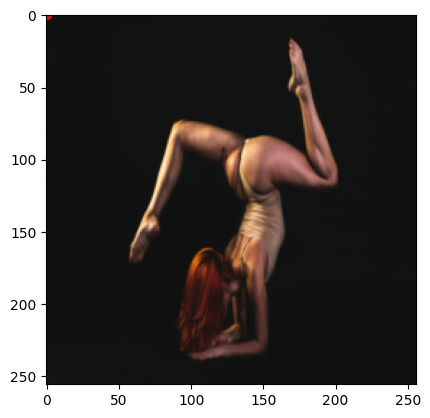

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize keypoints
def visualize_keypoints(image, keypoints):
    image = image.permute(1, 2, 0)  # Convert tensor to image format
    plt.imshow(image)
    for x, y in keypoints:
        plt.scatter(x, y, c='r', s=20)
    plt.show()

# Get a batch of images and their predictions
images, _ = next(iter(dataloader))
outputs = model(images)

# Visualize the first 5 images and their predicted keypoints
for i in range(5):
    visualize_keypoints(images[i], outputs[i].detach().numpy())


In [ ]:
# Save the model for later use
torch.save(model.state_dict(), 'pose_estimation_model.pth')